# Классификация - копаем глубже

> 🚀 В этой практике нам понадобятся: `numpy==1.26.4, pandas==2.2.2, scikit-learn==1.4.2` 

> 🚀 Установить вы их можете с помощью команды: `%pip install numpy==1.26.4 pandas==2.2.2 scikit-learn==1.4.2` 


## Содержание

* [Посмотрим на данные](#Посмотрим-на-данные)
* [Лирический отступ на стратификацию](#Лирический-отступ-на-стратификацию)
* [Обратно к самому главному](#Обратно-к-самому-главному)
* [Confusion matrix (Матрица ошибок)](#Confusion-matrix-Матрица-ошибок)
* [Вернёмся к accuracy](#Вернёмся-к-accuracy)
* [Двигаемся глубже](#Двигаемся-глубже)
* [Почему гармоническое среднее?](#Почему-гармоническое-среднее?)
* [Инструментарий](#Инструментарий)
* [Вывод](#Вывод)
* [Для затравки](#Для-затравки)
* [Вопросы для закрепления](#Вопросы-для-закрепления)
* [Полезные ссылки](#Полезные-ссылки)


Приветствуем! Вы уже познакомились с тем, что такое задача классификации и даже смогли сделать свою первую классифицирующую модель - замечательно!

Сегодня мы поговорим о том, как более подробно изучить поведение модели классификации. Ведь, по одной только точности (числу accuracy) слишком сложно что-то оценить. Давайте посмотрим другие способы анализа качества работы модели.

In [1]:
# Настройки для визуализации
# Если используется темная тема - лучше текст сделать белым
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
TEXT_COLOR = "black"

plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["text.color"] = TEXT_COLOR
plt.rcParams["font.size"] = 14
plt.rcParams["lines.markersize"] = 15
plt.rcParams["axes.labelcolor"] = TEXT_COLOR
plt.rcParams["xtick.color"] = TEXT_COLOR
plt.rcParams["ytick.color"] = TEXT_COLOR

sns.set_style("darkgrid")

# Зафиксируем состояние случайных чисел
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

## Посмотрим на данные

Допустим датасет собран из магазина, а предсказывать мы хотим факт покупки товаров, чтобы в будущем говорить, купят товар или нет.

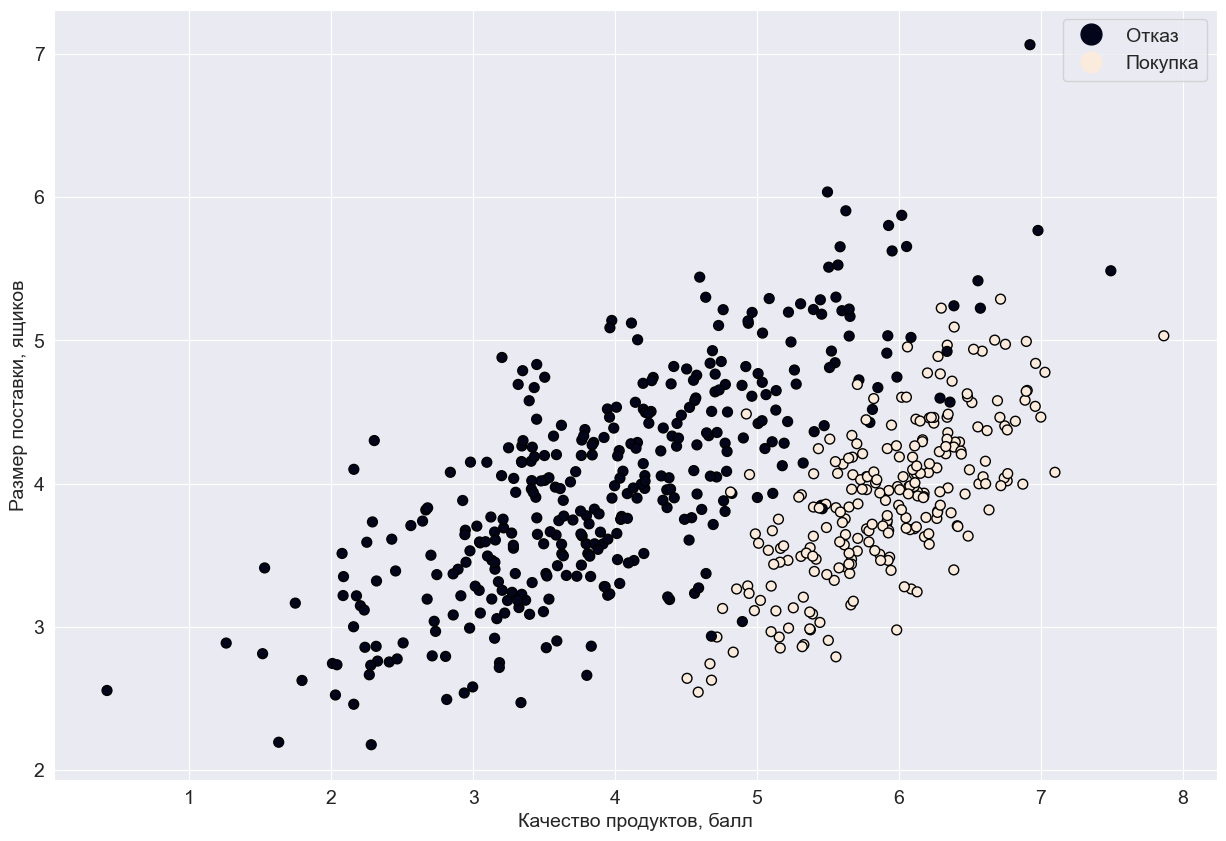

In [2]:
from sklearn.datasets import make_classification

X_data, y_data = make_classification(
    n_samples=600,
    n_features=2, 
    n_redundant=0,
    n_informative=2, 
    n_clusters_per_class=1,
    random_state=RANDOM_SEED,
    shift=[5, 3],
    weights=[0.6, 0.4]
)

df_data = pd.DataFrame(X_data, columns=["Качество", "Размер"])
df_data["Факт покупки"] = y_data
df_data["Факт покупки"] = df_data["Факт покупки"].map({0: "Отказ", 1: "Покупка"})

pnts_scatter = plt.scatter(X_data[:, 0], X_data[:, 1], marker="o", c=y_data, s=50, edgecolor="k")
plt.xlabel("Качество продуктов, балл")
plt.ylabel("Размер поставки, ящиков")
plt.grid(True)
plt.legend(handles=pnts_scatter.legend_elements()[0], labels=["Отказ", "Покупка"])
plt.show()

Смотрите, это наши данные, которые мы получили из базы данных (например) и **наша задача** заключается в том, чтобы предсказать, купят ли новые товары, поставка которого имеет определенный размер и оценка качества этой поставки имеет какой-то балл, или нет.

Для начала, как обычно смотрим на данные:

In [3]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Качество      600 non-null    float64
 1   Размер        600 non-null    float64
 2   Факт покупки  600 non-null    object 
dtypes: float64(2), object(1)
memory usage: 14.2+ KB


In [4]:
df_data

,Качество,Размер,Факт покупки
0,3.222604,3.094918,Отказ
1,3.594710,3.425859,Отказ
2,4.340039,4.387649,Отказ
3,6.178246,3.932423,Покупка
4,2.997050,2.578983,Отказ
...,...,...,...
595,3.395270,4.578392,Отказ
596,4.391365,3.961252,Отказ
597,4.672200,4.051398,Отказ
598,4.087367,3.756672,Отказ


Как видим, данные представляют собой две независимые переменные (числовые) и одна колонка зависимая (целевая), которая имеет **категориальный тип**. Пропусков в данных нет.

> 🤓 **Числовой** тип переменной - данные представлены вещественными или целыми числами.

> 🤓 **Категориальный** тип переменной - данные являются повторяющимися классами. То есть, на всю колонку есть несколько уникальных значений, которые и заполняют колонку.

Мы ещё позже подробнее узнаем новый тип переменной (категориальный) и на практике его достаточно часто будем применять! А сейчас, давайте посмотрим, какие уникальные значения есть в целевой колонке и какое их соотношение:

In [5]:
df_data["Факт покупки"].value_counts()

Факт покупки
Отказ      359
Покупка    241
Name: count, dtype: int64

Отлично, количество классов в данных сбалансировано. 

Что такое **дисбаланс в данных** - тема отдельная, а пока мы видим, что соотношение примеров одного класса к другому близко к единице. Значит, можно не беспокоиться. Вот если у вас в данных соотношение количество примеров одного класса к количеству примеров другого больше 3-5 раз, то надо принимать меры.

> ⚠️ Как правило, нельзя сказать определённый порог, при котором мы видим дисбаланс. Обычно, соотношение 1:1 - отсутствие дисбаланса, а вот превышение одного класса над другим раза в 3 уже можно считать дисбалансом. Мы сегодня будем знакомиться с новыми показателями, которые будем часто применять. Так как даже в случае соотношения 1:2 могут быть негативные последствия, новые метрики позволят увидеть это.

Чего нам не хватает, чтобы попробовать обучить простую модель? Правильно! В наших данных целевая колонка имеет строковый тип, но при этом категориальный, так как на всю колонку всего два уникальных значения. Значит, нужно разделить данные и закодировать целевую колонку!

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 

df_train, df_test = train_test_split(df_data, test_size=0.3, stratify=df_data["Факт покупки"], random_state=RANDOM_SEED)

y_train = df_train.pop("Факт покупки")
y_test = df_test.pop("Факт покупки")

target_enc = LabelEncoder()
target_enc.fit(y_train)

y_train_enc = target_enc.transform(y_train)
y_test_enc = target_enc.transform(y_test)

print(f"Train/test shapes: {df_train.shape}, {df_test.shape}")
print(target_enc.classes_)

Train/test shapes: (420, 2), (180, 2)
['Отказ' 'Покупка']


## Лирический отступ на стратификацию

Отлично, целевая колонка закодирована, чтобы в модель пошли не строки, а числа. 

Мы честно выделили выборку данных для тестирования, но что такое флаг `stratify`??

А вы знаете, что такое **стратификация** при разделении данных? 

Это очень важный аспект, когда мы работаем с данными для классификации!

Представьте, что у нас 1000 примеров (из них всего 20 примеров класса "Отказ", остальные - "Покупка") в датасете и надо выделить 30% - это 300 примеров. Как вы считаете, какая вероятность того, что все 20 примеров "Отказ" попадут в тест? К чему это приведет?

> ✨ Попробуйте обсудить это с преподавателем

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/think_about_it_image.png" width=600/></p>

А приведёт это к тому, что обучающая выборка будет состоять только из примеров "Покупка"! Так и чему будет учиться модель? 

**Ничему** - она будет думать, что всегда надо просто предсказывать "Покупка" и даже не будет знать об "Отказах". Это очень плохо!

Так вот **стратификация** позволяет сохранить соотношение классов изначальной выборки и присвоить такое же соотношение как train, так и test выборке.

В случае с 1000 классами в train обязательно попадет 14 примеров "отказа" и 686 примеров "покупки". В test - 6 примеров "отказа" и 294 примера "покупки".

> ⚠️ Изначально "отказ" имел соотношение $20/1000 = 0.02$, "покупка" - $980/1000 = 0.98$. Теперь смотрим train: $14/700 = 0.02$, $686/700 = 0.98$. Аналогично вы увидите в test выборке. В задаче классификации крайне рекомендуется использовать стратификацию!

Отлично, мы разобрались, что такое стратификация и зачем её применять, а теперь вернёмся к обучению!

## Обратно к самому главному

In [7]:
# TODO - реализуйте функцию train_logreg_model(), которая на вход принимает DataFrame, целевую колонку и выдаёт обученную модель логистической регрессии
#           Не забывайте фиксировать random_state !
from sklearn.linear_model import LogisticRegression

def train_logreg_model(X_data, y_data):
    model = LogisticRegression(random_state=42)
    model.fit(X_data, y_data)
    return model

In [8]:
# TEST

_test_X_data, _test_y_data = make_classification(
    n_samples=100,
    n_features=2, 
    n_redundant=0,
    random_state=RANDOM_SEED,
)

_test_model = train_logreg_model(_test_X_data, _test_y_data)

np.testing.assert_array_almost_equal(_test_model.coef_, [[3.232, -0.845]], decimal=3)

print("Well done!")

Well done!


Замечательно! Давайте посмотрим, какая точность нашего решения!

In [9]:
from sklearn.metrics import accuracy_score

logreg = train_logreg_model(df_train, y_train_enc)

y_pred = logreg.predict(df_test)

accuracy_value = accuracy_score(y_test_enc, y_pred)

print(f"Accuracy value: {accuracy_value}")

Accuracy value: 0.95


Вооу, вы только поглядите! Мы получили больше 90% точности! Так на что же нам жаловаться? Давайте скажем, что это очень высокая точность и двинем дальше.

Ну, нет, в анализе данных важно стараться как можно лучше понять, по каким причинам происходит то или иное предсказание. Давайте попробуем разобраться!

Один из самых простых подходов - взять и посмотреть, где и как предсказывает модель в случае ошибок:

In [10]:
for y_p, y_t in zip(y_pred, y_test_enc):
    if y_t != y_p:
        print(f"Predict {y_p} vs True {y_t}")

Predict 1 vs True 0
Predict 1 vs True 0
Predict 1 vs True 0
Predict 1 vs True 0
Predict 1 vs True 0
Predict 0 vs True 1
Predict 1 vs True 0
Predict 0 vs True 1
Predict 1 vs True 0


Смотрите, у нас в большинстве случаев модель предсказывает 1 (Покупка), хотя на деле был 0 (Отказ). Мы смогли таким образом вывести пару примеров, но что если данных будет под миллион записей и ошибок будет куча? 

Это очень кропотливый труд и есть более удобные способы **анализа модели классификации**!

Так как же нам проанализировать поведение модели, если при таком плохом случае accuracy говорит, что у нас очень даже хорошо? 

Начнем с основ!

## Confusion matrix (Матрица ошибок)

Confusion matrix (CM) - это матрица, которая показывает не только ошибки (как можно подумать из названия), но и правильные предсказания. 

Давайте посмотрим, как она выглядит в общем виде:

<table align="center">
    <thead>
        <tr>
            <th colspan=2></th>
            <th colspan=2>Предсказание</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=3>Истинное</td>
            <td></td>
            <td>0</td>
            <td>1</td>
        </tr>
        <tr>
            <td>0</td>
            <td>TN</td>
            <td>FP</td>
        </tr>
        <tr>
            <td>1</td>
            <td>FN</td>
            <td>TP</td>
        </tr>
    </tbody>
</table>


<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/21_confusion_matrix.png" width=600/></p>

> Помните, что 0 - Отказ, 1 - Покупка

В разборе нам пригодится понятие **положительного** и **отрицательного** классов. Эти понятия связаны с конечной задачей. То есть, если мы хотим проанализировать, как модель предсказывает "Покупку", то мы говорим, что класс "Покупка" (индекс 1) - **положительный**. Так как задача состоит из предсказания 2-х классов, то другой становится **отрицательным**.

<details>
<summary>А что, если хочется сделать класс 0 положительным?</summary>
На самом деле нам ничего не мешает сказать, что класс 0 (Отказ) - положительный, класс 1 (Покупка) становится отрицательным. Тогда анализ производится похожим образом, но инверсно, и мы будем анализировать качество работы модели на предсказание класса "Отказ".
</details>

Так вот, определили, что класс 1 - положительный, тогда разбор четырёх показателей станет намного проще!

- **TP** - количество правдиво положительных (true positive), это сколько раз мы верно предсказали положительный класс. То есть, сколько раз мы предсказали примеры с истинным классом 1 как 1.
- **TN** - количество правдиво отрицательных (true negative), тоже самое, но про отрицательный класс, сколько раз мы правильно предсказали истинные 0 как 0. Не путайтесь в том, что здесь есть слово отрицательный! Это не *плохой* показатель, а просто про отрицательный класс (не положительный).
- **FP** - количество ложных положительных (false positive), а вот это уже количество примеров, которые были предсказаны как положительный класс (класс Покупка - 1), но на деле таковым не являющиеся. Мы предсказали как положительный, но ошиблись. То есть, сколько раз мы истинный *Отказ* предсказали как *Покупка*.
- **FN** - количество ложных отрицательных (false negative), это обратная к FP ситуация. Количество ошибок, когда мы предсказали как отрицательный класс, но это неправильно. То есть, сколько раз мы предсказали истинную *Покупку* как *Отказ*.

> 🤓 **FP** еще называется **ошибкой первого рода**

> 🤓 **FN** еще называется **ошибкой второго рода**

Если всё ещё не очень понятно, что это за зверь такой, можете глянуть дружелюбный [видосик](https://www.youtube.com/watch?v=CXahhigetdAhttps://www.youtube.com/watch?v=CXahhigetdA).

Так вот, такая матрица показывает, в каких ситуациях мы ошибаемся.

Давайте напишем код, который на основе двух векторов (вектор истинных индексов и вектор предсказанных индексов) создаёт матрицу 2х2 с заполненными значениями:

In [11]:
# TODO - напишите код расчета CM. CM - матрица размером 2х2. Функция create_CM(), которая принимает y_true - вектор истинных индексов, y_pred - вектор предсказанных
def create_CM(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    return cm

In [12]:
# TEST

_test_y_true = np.array([1, 1, 1, 0, 0, 1, 1, 0, 0])
_test_y_pred = np.array([1, 1, 1, 1, 0, 1, 0, 1, 0])

result_cm = create_CM(_test_y_true, _test_y_pred)

_test_expected_cm = np.array([
    [2, 2], [1, 4]
])

np.testing.assert_array_almost_equal(_test_expected_cm, result_cm)

print("Well Done!")

Well Done!


ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ

Отлично, молодцы, теперь смотрим, какие у нас показатели:

In [13]:
data_cm = create_CM(y_test_enc, y_pred)

data_cm

array([[101,   7],
       [  2,  70]])

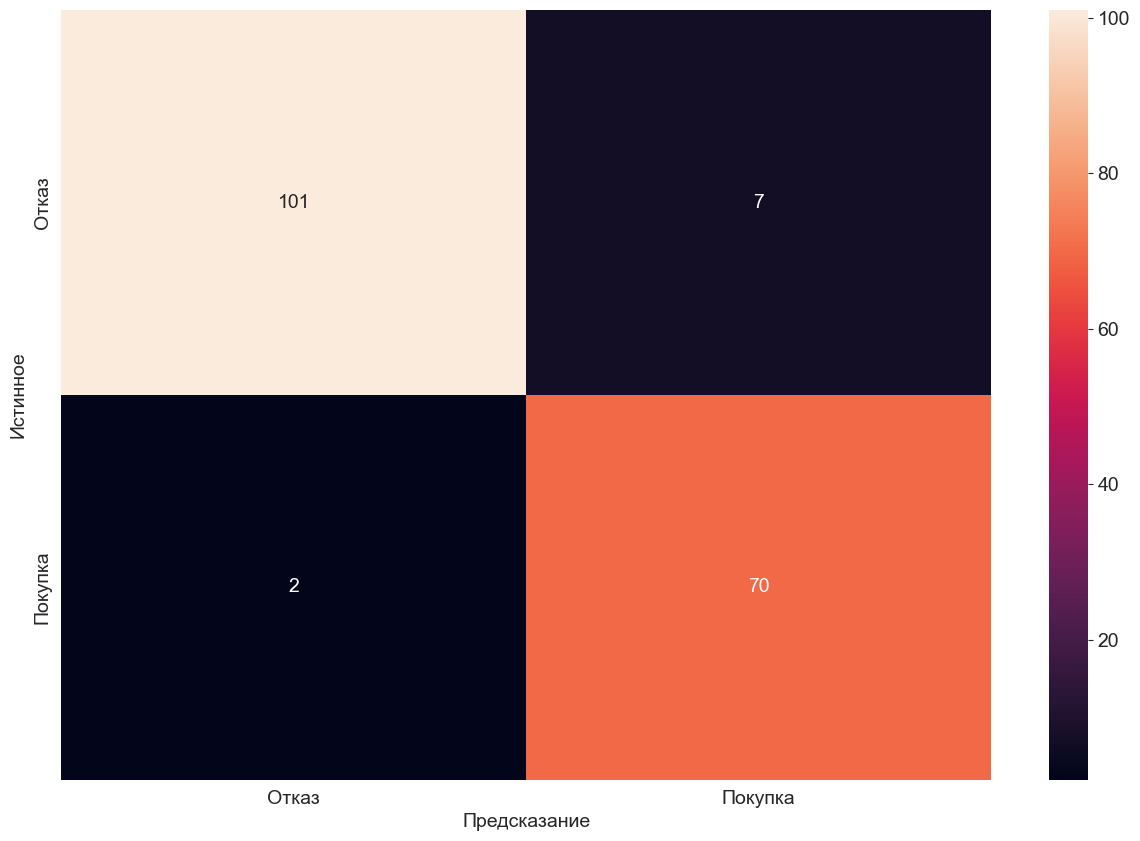

In [14]:
# Обычно проще смотреть на CM через отображенный Heatmap

def draw_heatmap(y_true, y_pred):
    data_cm = create_CM(y_true, y_pred)
    ax = sns.heatmap(data_cm, annot=True, fmt=".0f", xticklabels=["Отказ", "Покупка"], yticklabels=["Отказ", "Покупка"])
    ax.set_ylabel("Истинное")
    ax.set_xlabel("Предсказание")

draw_heatmap(y_test_enc, y_pred)

Как видим, CM - отличный простой способ отображения того, как модель себя ведёт! 

Тут мы сразу увидели, что модель ошибается, предсказывая Покупку, хотя на деле был Отказ. 

Далее, мы разберём другие показатели, которые это покажут, а сейчас важно запомнить, что CM - это хороший вариант, чтобы посмотреть базовые аспекты поведения модели вне зависимости от количества данных!

Всего мы видим: 70 TP, 101 TN, 2 FN и 7 FP.

> ⚠️ Confusion Matrix - это наиболее универсальный способ посмотреть на поведение классифицирующей модели. Не пренебрегайте им, так как он прост и очень показателен!

> ⚠️ Хотите маленький трюк? Если сложить значения в каждой строке матрицы CM, то можно узнать сколько примеров одного и другого класса. Например, мы сразу узнаем, что класс "Покупка" - 2+70 примеров, а класса "Отказ" - 101+7. Можете это проверить!

## Вернёмся к accuracy

Так как мы уже знаем термины TP, FN и другие, то мы можем более научно сформулировать формулу accuracy! Вот же она:

$$
Accuracy = \frac{TP+TN}{TP+TN+FP+FN}
$$

По сути, это количество всех правильно предсказанных примеров, деленное на количество всех примеров!

Что важно понимать о Accuracy - эта метрика не зависит от того, какой класс выбран положительным. Это и хорошо и плохо, так как это позволяет быстро и в общем виде сделать оценку, **но** этот показатель не дает подробностей. Просто, сколько раз мы правильно предсказали.

## Двигаемся глубже

Так что мы имеем на данный момент? 
- Мы можем оценить одним числом (accuracy) то, насколько модель попадает в предсказания, но при определённых условиях это число может быть обманчиво.
- Мы можем построить визуальное представление количеств правильно и неправильно предсказанных примеров (матрица ошибок). По нему уже можно видеть, в каких классах и насколько модель ошибается, но что с этим делать дальше??

По сути, все эти TP, FP и другие в виде heatmap показывают, где модель ошибается, но эти показатели в чистом виде трудно обобщить. 

А что если мы попробуем покомбинировать показатели? Начнём с первого варианта:

$$
\frac{TP}{TP+FN} = \frac{3}{3+3} = 0.5
$$

Что такое соотношение даёт? Мы видим, насколько полно предсказание заполнено положительным классом. 

То есть, FN в знаменателе указывает, что если бы мы никогда не предсказывали FN (предсказать 0, а на деле это 1), то есть никогда не предсказывали бы 0 вообще, а всегда 1, то даже в таком случае показатель был бы **единица**!

Давайте на примере:
```
y_true = [0, 1, 1, 0, 0, 1, 1, 1]
y_pred = [1, 1, 1, 1, 1, 1, 1, 1]
```

Сколько в этом примере ложно положительных? FN = 0! 

Тогда $\frac{TP}{TP+FN} = 1$! То есть, такое соотношение говорит, насколько **полно** мы предсказываем положительный класс - насколько предсказания плотно заполняют истинные положительные примеры.

Название этому показателю - **Recall** (полнота).

$$
Recall = \frac{TP}{TP+FN}
$$

Другой показатель немного по-другому работает, но формула очень похожа!

$$
\frac{TP}{TP+FP} = \frac{3}{3+0} = 1.0
$$

Смотрите, в нашем случае именно этот показатель равен 1! 

Но почему так? Потому что этот показатель оценивает, насколько модель **попадает в предсказании** положительного класса.

```
y_true = [0, 1, 1, 0, 0, 1, 1, 1]
y_pred = [0, 1, 1, 0, 0, 0, 0, 0]
```

Вот в  этом примере FP=0! 

То есть, модель никогда случайно не назовёт отрицательный класс (0) положительным (1). Да, бывает, что не узнает истинные положительные, но помните, полноту предсказания положительного класса оценивает другой показатель - Recall.

А этот показатель акцентируется на **отсутсвии промахов**  в предсказании положительного. Такой эффект называют высокой **точностью**, но не путайте с accuracy! Название ему Precision:

$$
Precision = \frac{TP}{TP+FP}
$$

> ⚠️ Recall хорош для оценки, когда нам нужно понимать, насколько модель ведёт себя уверенно. Например, в медицине, нам важнее сказать, что истинно больной (1) пациент - больной (1), так как если назвать здорового человека больным, то он просто сходит и сдаст анализы ещё раз, а вот пропустить больного - может быть очень опасно. 

> Если мы совершим ошибку и скажем, что здоровый (0) пациент болен (1), то мы совершим ошибку FP и это уменьшит Precision. Если скажем, что больной пациент (1) здоров (0), то это будет ошибка FN - это уменьшит Recall. 

> Нам важно не пропустить больных пациентов, поэтому в таких задачах надо добиваться максимального Recall, чтобы был минимум ошибок FN!

---

> ⚠️ Для Precision может быть примером другая задача. Разрабатывается система полива сада. Наша модель классифицирует, надо поливать сад (1) или ещё нет (0). Если в ситуации, когда не надо было поливать (0), наша система неправильно это классифицировала и начала полив (1), то это может навредить растениям и они завянут (FP). Если наоборот, надо полить (1), а мы классифицировали, что нет (0), то это не так страшно, так как может прийти человек и перепроверить (FN). Так вот, мы пытаемся свести FP к минимуму, поэтому максимизируем Precision!

Так что нам дают эти два показателя? По сути, один показывает, насколько мы уверенно предсказываем положительный класс, а другой, насколько **не** промахиваемся. По отдельности эти два показателя тоже имеют плюсы, но мы попробуем их совместить с помощью математического трюка под названием **гармоническое среднее**!

$$
F_1 = 2*\frac{Recall*Precision}{Recall+Precision} = 2*\frac{1.0*0.5}{1.0+0.5} = 0.667
$$

Гармоническое среднее Precision и Recall зовётся **F1**. Это способ усреднить Precision и Recall, чтобы оценить, насколько хорошо модель работает в целом. 

Как видите, из-за того, что наша моделька имеет хорошую точность, но полнота сильно страдает, то F1 = 0.667. Это уже ближе к правде, нежели оценка accuracy = 95%!

> 🤓 Если интересно, вы ещё можете почитать о $F_2$ и $F_{0.5}$, которые делают смещение в определённые акценты. Они не так часто распространены, но о них можно изредка услышать.

Таким образом, мы научились оценивать систему с помощью показателя, который не обманешь дисбалансом! 

Он сразу выявляет, что система не совсем точна, и надо что-то делать! 

Но всё это пустые разговоры без кода, погнали:

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/okay_lets_go.jpg" width=600/></p>


In [15]:
# TODO - напишите функцию compute_classification_metrics(), который принимает y_true - вектор истинных индексов, y_pred - вектор предсказанных
#           Функция должна возвращать dict с ключами recall, precision, f1, accuracy

def compute_classification_metrics(y_true, y_pred):
    from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

    metrics = {
        'recall': recall_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'accuracy': accuracy_score(y_true, y_pred)
    }

    return metrics


In [16]:
compute_classification_metrics(y_test_enc, y_pred)


{'recall': np.float64(0.9722222222222222),
 'precision': np.float64(0.9090909090909091),
 'f1': np.float64(0.9395973154362416),
 'accuracy': 0.95}

In [17]:
# TEST

_test_y_true = np.array([1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1])
_test_y_pred = np.array([1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1])

_test_metrics = compute_classification_metrics(_test_y_true, _test_y_pred)

_test_expected_metrics = {
    "recall": 0.8333333333333334,
    "precision": 0.625,
    "f1": 0.7142857142857143,
    "accuracy": 0.6363636363636364
}

assert _test_expected_metrics == _test_metrics

print("Well done!")

Well done!


Отлично, молодцы! А теперь проверим на наших данных!

In [18]:
metrics = compute_classification_metrics(y_test_enc, y_pred)
metrics

{'recall': np.float64(0.9722222222222222),
 'precision': np.float64(0.9090909090909091),
 'f1': np.float64(0.9395973154362416),
 'accuracy': 0.95}

Глядите, всё так, как мы посчитали!

Теперь у нас есть инструмент - показатель, который позволяет оценить то, насколько действительно хорошо наша модель работает! Шикарные новости!

Как видим, из-за того, что модель иногда на Отказ предсказывает Покупку, показатель Precision немного просел. В результате, F1 значение меньше, чем accuracy и это важно, так как F1 показывает качество предсказания модели в данном случае только по классу "Покупка".

## Почему гармоническое среднее?

Вы, наверное, обратили внимание, что F1 - это не просто усреднение Recall и Precision, а именно гармоническое среднее! Давайте попробуем разобраться, почему так, и сделаем это через графики!

Вот так выглядит график среднего, если усредняем x и y в диапазоне [0; 100]:

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/plot_mean.jpg" width=600/></p>

А вот так выглядит график гармонического среднего со степенью 1:

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/plot_harmonic_mean.jpg" width=600/></p>

Если вы ещё не заметили разницу, то обратите внимание на края графиков:

- в случае среднего, даже если x = 0, а y = 100, то мы получаем 50
- в случае гармонического среднего близость хотя бы одного показателя к 0 даёт в результате ноль вне зависимости от второго.

Это важное свойство, потому что когда, например, модель просто всегда предсказывает положительный класс Recall = 1, но Precision близок к 0. Это не даёт нам обмануться значением F1 равным 0.5, а понять, что модель всё ещё работает "плохо" и вернуть F1 близкий к 0.

Вот такой простой математический трюк, а какой интересный результат!

## Инструментарий

Конечно же, никто не будет каждый раз реализовывать функции вычисления recall, precision, так как они уже давно существуют. 

Давайте проделаем маленькое задание и познакомимся с готовыми функциями, а также сравним наши реализации с готовыми:

- [recall_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)
- [precision_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) 
- [f1_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

Также, можно использовать реализацию расчёта CM: [confusion_matrix()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), [plot_confusion_matrix()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

В следующих нескольких ячейках произведите применение функций и сравните результаты с собственными реализациями:

In [19]:
def compute_classification_metrics(y_true, y_pred):
    from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

    metrics = {
        'recall': recall_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'accuracy': accuracy_score(y_true, y_pred)
    }
    data_CM = create_CM (y_true, y_pred)
    metrics2 = {
        'recall': (data_CM[0,0])/(data_CM[0,0] + data_CM[1,0]),
        'precision': (data_CM[0,0])/(data_CM[0,0] + data_CM[0,1]),
        'f1': f1_score(y_true, y_pred),
        'accuracy': (data_CM[0,0] + data_CM[1,1])/np.sum(data_CM)
    }
    return metrics, metrics2
compute_classification_metrics(y_test_enc, y_pred)

({'recall': np.float64(0.9722222222222222),
  'precision': np.float64(0.9090909090909091),
  'f1': np.float64(0.9395973154362416),
  'accuracy': 0.95},
 {'recall': np.float64(0.9805825242718447),
  'precision': np.float64(0.9351851851851852),
  'f1': np.float64(0.9395973154362416),
  'accuracy': np.float64(0.95)})

## Вывод

В этой главе мы познакомились с очень важными инструментами!

Во-первых, стратификация - маленький аспект, а очень важное значение в задаче классификации (равномерное распеределение классов по выборкам)!

Во-вторых, новые способы проанализировать модель в целом - accuracy и Confusion Matrix, а ещё новые способы провести анализ качества предсказания конкретного класса - Recall, Precision, F1.

В-третьих, пополнили свои навыки пониманием того, что часто задача не просто сводится к увеличению accuracy, а часто, в зависимости от специфики задачи, важно оценивать и максимизировать ещё и отдельные показатели.

## Для затравки

Вы помните, что в предыдущей практике говорили о сигмоиде и принятии решения? 

Немного напомним, в логистической регрессии (бинарной классификации) применяется функция сигмоиды:

Text(0, 0, 'Отказ')

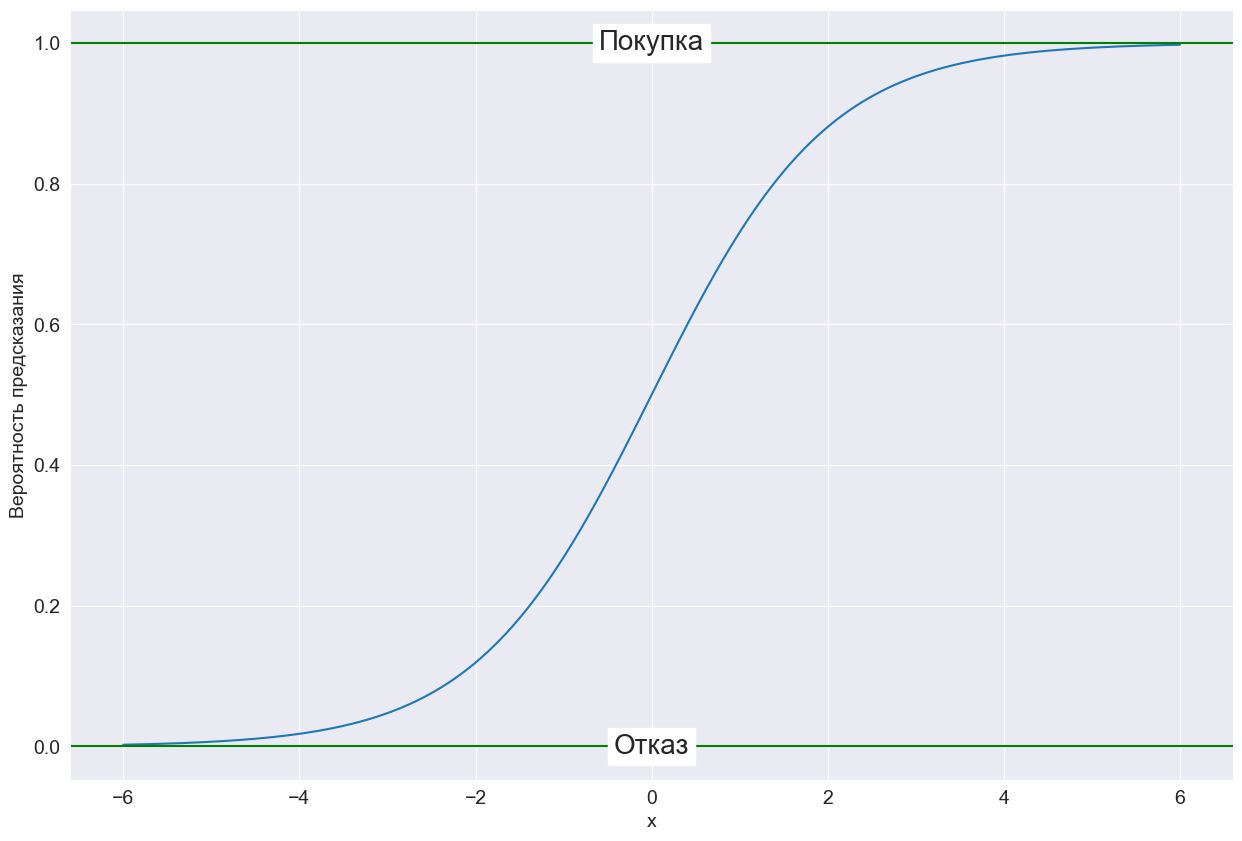

In [20]:
_plot_x = np.linspace(-6, 6, 1000)
_plot_y =  1 / (1 + np.exp(-_plot_x))

plt.plot(_plot_x, _plot_y)
plt.xlabel("x")
plt.ylabel("Вероятность предсказания")

plt.axhline(1, color="g")
plt.axhline(0, color="g")

plt.text(0, 1, "Покупка", fontsize=20, va="center", ha="center", backgroundcolor="w")
plt.text(0, 0, "Отказ", fontsize=20, va="center", ha="center", backgroundcolor="w")


Мы видели, что модель предсказывает только 0 или 1, но на деле внутри модели до **принятия решения** существует вероятность предсказания (Y ось на графике). Эта вероятность говорит, к какому классу больше относится предказание - "Покупка" или "Отказ".

По умолчанию метод `predict()` принимает решение на основе границы 0.5, то есть, если вероятность выше 0.5 - это класс Покупка, а если ниже - Отказ.

Давайте проверим, для начала посмотрим вывод метода [predict_proba()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba), который возвращает сырые вероятности:

In [21]:
y_probs = logreg.predict_proba(df_test)

print(y_probs)

[[2.90058245e-02 9.70994175e-01]
 [1.54032268e-01 8.45967732e-01]
 [9.22555713e-01 7.74442872e-02]
 [7.84093264e-03 9.92159067e-01]
 [9.99943189e-01 5.68105739e-05]
 [3.74209104e-01 6.25790896e-01]
 [9.82746814e-01 1.72531857e-02]
 [9.99353090e-01 6.46910212e-04]
 [1.98364934e-02 9.80163507e-01]
 [9.99962975e-01 3.70251145e-05]
 [7.90099419e-01 2.09900581e-01]
 [7.83523992e-01 2.16476008e-01]
 [9.97314905e-01 2.68509536e-03]
 [2.15940889e-02 9.78405911e-01]
 [9.62545230e-01 3.74547705e-02]
 [5.86078463e-03 9.94139215e-01]
 [1.33183893e-01 8.66816107e-01]
 [9.99049723e-01 9.50277013e-04]
 [9.96795963e-01 3.20403724e-03]
 [9.95696851e-01 4.30314868e-03]
 [4.64319069e-02 9.53568093e-01]
 [1.54351811e-02 9.84564819e-01]
 [9.84413088e-01 1.55869125e-02]
 [9.99030207e-01 9.69793101e-04]
 [8.82763665e-03 9.91172363e-01]
 [2.66322773e-03 9.97336772e-01]
 [9.44512330e-01 5.54876705e-02]
 [9.93778144e-01 6.22185635e-03]
 [9.99654491e-01 3.45508737e-04]
 [1.07451915e-01 8.92548085e-01]
 [9.751250

Как видите, `predict_proba()` возвращает матрицу Nx2, в которой N - количество примеров в данных, а 2 - количество классов, которое мы предсказываем. В бинарной классификации мы можем воспользоваться вторым столбцом матрицы, так как первый - вероятность предсказания класса 0 (Отказ) и равна обратной вероятности предсказания класса 1 (Покупка).

> 🔥 Если вы не верите последнему факту - отлично! Критическое мышление важно - вы можете создать ячейку кода и проверить это самостоятельно. Достаточно сложить каждую строку в матрице и убедиться, что каждое сложение даёт единицу (или близкое к 1 значение до 6-го знака - могут быть неточности float вычислений).

Давайте попробуем вывести пару значений вероятностей и результатов `predict()`:

In [22]:
y_pred = logreg.predict(df_test)

match_matrix = np.c_[y_probs[:,1], y_pred]

_show_df = pd.DataFrame(match_matrix, columns=["Вероятность предсказания", "Предсказанный predict() класс"])
_show_df

,Вероятность предсказания,Предсказанный predict() класс
0,0.970994,1.0
1,0.845968,1.0
2,0.077444,0.0
3,0.992159,1.0
4,0.000057,0.0
...,...,...
175,0.003529,0.0
176,0.026320,0.0
177,0.993961,1.0
178,0.067381,0.0


Видите, если вероятность высока, то `predict()` возвращает 1, в ином случае - 0. 

Но это только просмотр части данных, давайте напишем свою функцию, которая на основе вероятностей будет давать вектор предсказаний: 

In [23]:
# TODO - напишите функцию принятия решения predict_threshold() на основе вероятностей из predict_proba().
#           Функция должна принимать матрицу вероятностей y_probs и порог принятия решения threshold

In [24]:
# TEST

_test_y_probs = np.array([
    [0.4, 0.6],
    [0.1, 0.9],
    [0.8, 0.2],
    [0.0, 1.0],
    [0.7, 0.3]
])

_test_result = predict_threshold(_test_y_probs, 0.75)
_test_expected = np.array([0, 1, 0, 1, 0])

np.testing.assert_allclose(_test_result, _test_expected)

print("Well done!")

NameError: name 'predict_threshold' is not defined

Замечательно, а теперь проверим, действительно ли `predict()` даёт то же самое, что и `predict_proba()` с порогом 0.5?

In [ ]:
y_pred_05 = predict_threshold(y_probs, 0.5)
np.allclose(y_pred, y_pred_05)

In [ ]:
# Так а теперь проверим, что при смене порога что-то меняется:
y_pred_06 = predict_threshold(y_probs, 0.6)
np.allclose(y_pred, y_pred_06)

Замечательно! Вот так мы раскрыли хитрость работы логистической регрессии!

Только зачем нам это нужно? А давайте взглянем на метрики после изменения порога:

In [ ]:
compute_classification_metrics(y_test_enc, y_pred_05)

In [ ]:
compute_classification_metrics(y_test_enc, y_pred_06)

In [ ]:
y_pred_07 = predict_threshold(y_probs, 0.7)
compute_classification_metrics(y_test_enc, y_pred_07)

Смотрите! С увеличением порога растёт Precision, но падает Recall! Получается, с уменьшением порога, растёт Recall, но падает Precision.

Вот это да! Получается, что мы можем управлять интересующей нас метрикой с помощью порога принятия решение! Вау, так просто!

Но есть и обратная сторона этой радости, получается, нам нужно как-то настроить параметр на подходящее значение...

Не переживайте, скоро мы научимся парочке трюков, а пока просто осознайте и запомните, что предсказания - это не просто конкретный индекс класса, а вероятности, с которыми можно работать!

## Вопросы для закрепления

А теперь пара вопросов, чтобы закрепить материал!

1. Какие могут быть причины высокого accuracy, но низкого F1?
2. Какую метрику лучше максимизировать, если вы разрабатываете систему предсказания возврата кредита для банка. Если человек возвращает (1), то это очень хорошо и банк получает прибыль, если нет (0) - плохо, банк теряет деньги. Вам важно предсказывать, что человек действительно вернёт и лучше лишний раз отказать (0) тому, кто вернёт (1), чем дать кредит тому (1), кто не вернёт (0).
3. Методы sklearn по расчету scores считают показатели для класса 1 как положительного. Что нужно сделать, чтобы посчитать метрики для класса 0 как положительного?
4. Попробуйте предположить, как принимается решение, если предсказание делается не на двух классах, а, например, пяти?
5. Как, используя [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), из индексов получить исходные названия классов?

## Полезные ссылки
* [The Confusion Matrix от StatQuest](https://www.youtube.com/watch?v=Kdsp6soqA7o)
* [Sensitivity and Specificity от StatQuest](https://www.youtube.com/watch?v=vP06aMoz4v8)
